# Тюнинг линейной регрессии и ошибки

### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии

In [165]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.13/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Часть 1. Линейная регрессия

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3. Зачем так делать? Когда вы проверяете себя на данных на которых не обучались, вы можете быть уверены что не переобучились. Таким образом если качество на 70% датасета (оубчающей выборке) растёт, а на тестовой выборке падает, то модель начала запоминать датасет (переобучилась), вы что-то делаете не так.


In [166]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241) # type: ignore

__Задание 1.__ Обучение линейной регрессии.

**(4 балла)**

Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$).

Спойлер - при большом гиперпараметре регуляризации все параметры стремятся к нулю. На графике это должно быть видно.

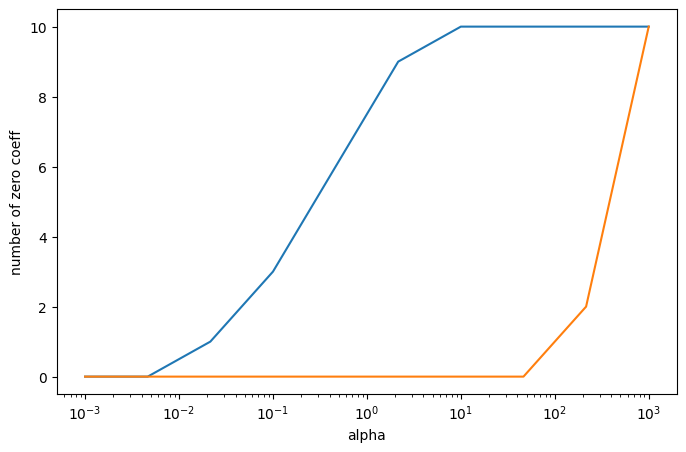

In [167]:
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, Lasso
import numpy as np
import matplotlib.pyplot as plt

alphas = np.logspace(-3, 3, 10)

lasso_nz = []
ridge_nz = []

for alpha in alphas:
    lasso_nz.append(np.sum(np.abs(Lasso(alpha=alpha).fit(X_train, y_train).coef_) < 0.1))
    ridge_nz.append(np.sum(np.abs(Ridge(alpha=alpha).fit(X_train, y_train).coef_) < 1))

plt.figure(figsize=(8, 5))
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('number of zero coeff')

plt.plot(alphas, lasso_nz)
plt.plot(alphas, ridge_nz)

plt.show()


Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

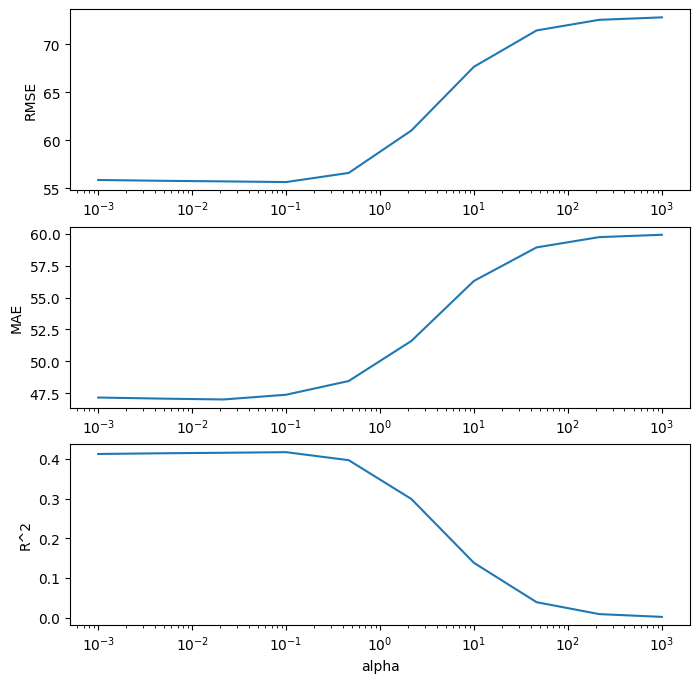

In [168]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

alphas = np.logspace(-3, 3, 10)

ridge_rmse = []
ridge_mae = []
ridge_r2 = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    ridge_rmse.append(sqrt(mean_squared_error(y_test, y_pred)))
    ridge_mae.append(mean_absolute_error(y_test, y_pred))
    ridge_r2.append(r2_score(y_test, y_pred))

# print("mse: ", ridge_rmse)
# print("mae: ", ridge_mae)
# print("r2: ", ridge_r2)

plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
plt.xscale('log')
plt.plot(alphas, ridge_rmse)
plt.ylabel('RMSE')
plt.subplot(3, 1, 2)
plt.xscale('log')
plt.plot(alphas, ridge_mae)
plt.ylabel('MAE')
plt.subplot(3, 1, 3)
plt.xscale('log')
plt.plot(alphas, ridge_r2)
plt.ylabel('R^2')
plt.xlabel('alpha')
plt.show()

Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

In [169]:
best_alpha = 0.1 # примерно лучшая alpha
ridge = Ridge(alpha=best_alpha).fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_rmse = sqrt(mean_squared_error(y_test, y_pred))
ridge_mae = mean_absolute_error(y_test, y_pred)
ridge_r2 = r2_score(y_test, y_pred)

old_ridge_rmse = ridge_rmse
old_ridge_mae = ridge_mae
old_ridge_r2 = ridge_r2

print("mse: ", ridge_rmse)
print("mae: ", ridge_mae)
print("r2: ", ridge_r2)

mse:  55.641761224049134
mae:  47.3754637570613
r2:  0.41702880920983454


__Задание 2.__ Поиск объектов-выбросов

**(4 балла)**

Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

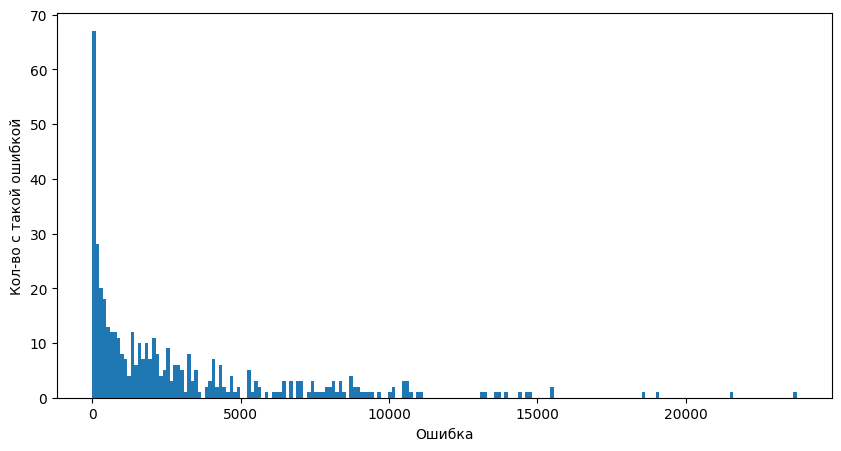

In [170]:
from numpy import average


model = Ridge(alpha=0.1)

x = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
model.fit(x, y)
y_pred = model.predict(x)

err = (y_pred - y) ** 2

# print(max(ridge_mse))
# print(average(ridge_mse))
plt.figure(figsize=(10, 5))
plt.hist(err, bins=200)

plt.xlabel('Ошибка')
plt.ylabel('Кол-во с такой ошибкой')

plt.show()

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

In [171]:
delete_error = 10000

print("old len x: ", len(x))
print("old len y: ", len(y))
old_xtest = X_test.copy()
old_ytest = y_test.copy()
x = x[(err < delete_error).flatten()]
y = y[(err < delete_error).flatten()]

print("new len x: ", len(x))
print("new len y: ", len(y))

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=241)
model.fit(X_train, y_train)
y_pred = model.predict(old_xtest)

new_ridge_rmse = sqrt(mean_squared_error(old_ytest, y_pred))
new_ridge_mae = mean_absolute_error(old_ytest, y_pred)
new_ridge_r2 = r2_score(old_ytest, y_pred)

print("old rmse: ", old_ridge_rmse)
print("new rmse: ", new_ridge_rmse)
print("old mae: ", old_ridge_mae)
print("new mae: ", new_ridge_mae)
print("old r2: ", old_ridge_r2)
print("new r2: ", new_ridge_r2)


old len x:  442
old len y:  442
new len x:  417
new len y:  417
old rmse:  55.641761224049134
new rmse:  51.92183989081013
old mae:  47.3754637570613
new mae:  44.07615484635645
old r2:  0.41702880920983454
new r2:  0.49237207590583987


__Задание 3.__ Отчёт

**(2 балла)**

после удаления выбросов качество модели улучшилось

RMSE улучшилось с 55.64 до 51.92
MAE улучшилось с 47.37 до 44.07
R^2 улучшилось с 0.41 до 0.49